<h2 align="center">Vehicle Damage Detection Project</h2>

In [9]:
# import libraries
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna

### Load Data

In [10]:
# Define a series of image preprocessing and data augmentation steps:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), #randomly rotates the image within ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225]) #normalizes image channels using ImageNet statistics to match pretrained model expectations
])

In [11]:
# Load the dataset from the given path and apply predefined image transformations
dataset_path = "../dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)

# Total number of images in the dataset
len(dataset)

2300

In [12]:
# List all classes in the dataset
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [13]:
# Number of classes in the data
num_classes = len(dataset.classes)
num_classes

6

In [14]:
# train-test split (75% train)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [15]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
# Create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Loads training data in batches of 32 and shuffles them for each epoch
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True) #same for validation data

In [17]:
# Output image size (batch_size, 3 color channels(RGB), height, width)
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7511113].


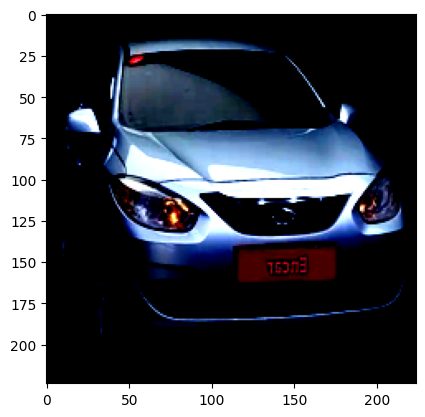

In [18]:
# Visualize the first image
plt.imshow(images[0].permute(1,2,0)) #rearranges it to (height, width, channels)
plt.show()

### Model 1: CNN

In [19]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            # First conv layer: input channels=3 (RGB), output channels=16
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(), # Non-linear activation
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Downsample by 2 → (16, 112, 112)

            # Second conv layer: 16 input channels, 32 output channels
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Downsample by 2  (32, 56, 56)reduces spatial size

            # Third conv layer: 32 input channels, 64 output channels
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Downsample by 2 (64, 28, 28)

            # Flatten feature maps into a vector of size 64*28*28 
            nn.Flatten(),
            # Fully connected layer reducing to 512 features
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)# Output layer for classification with num_classes outputs
        )
        
# Pass input through the defined layers sequentially
    def forward(self, x):
        x = self.network(x)
        return x

In [20]:
# Initialize the model with the number of output classes
model = CarClassifierCNN(num_classes=num_classes)

# Define the loss function as CrossEntropyLoss, suitable for multi-class classification
criterion = nn.CrossEntropyLoss()

# Set up the Adam optimizer to update model parameters with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train_model(model, criterion, optimizer, epochs=5):
    
    start = time.time() # Track start time for total training duration
    
    for epoch in range(epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        
        for batch_num, (images, labels) in enumerate(train_loader):
            
            # Clear gradients/initialize to 0 
            optimizer.zero_grad()
            
            # Forward pass/compute model predictions
            outputs = model(images)
            
            # Compute loss between predictions and labels
            loss = criterion(outputs, labels)

            # Backpropagate loss to compute gradients
            loss.backward()

            #Update model parameters
            optimizer.step()

            # Print loss every 10 batches
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
                
            # Sum loss weighted by batch size
            running_loss += loss.item() * images.size(0)

        # Average loss over epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss: .4f}")

        # Validation phase - evaluate model performance on val_loader
        model.eval()
        
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            
            for images, labels in val_loader:
                
                outputs = model(images)
                
                # Get predicted class indices
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                
                # Count correct predictions
                correct += (predicted == labels).sum().item()
                
                # Collect all true labels
                all_labels.extend(labels.numpy())
                
                # Collect all predicted labels
                all_predictions.extend(predicted.numpy())

            print(f"***Validation Accuracy: {100 * correct / total:.2f}%***")

    end = time.time()
    
    print(f"Execution: {end - start} seconds")
    
    # Return the collected true labels and predicted labels from the final epoch       
    return all_labels, all_predictions

In [22]:
# Train the model for 5 epochs
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.79
Batch: 40, Epoch: 1, Loss: 1.79
Batch: 50, Epoch: 1, Loss: 1.78
Epoch [1/5], Avg Loss:  1.9417
***Validation Accuracy: 20.35%***
Batch: 10, Epoch: 2, Loss: 1.72
Batch: 20, Epoch: 2, Loss: 1.67
Batch: 30, Epoch: 2, Loss: 1.26
Batch: 40, Epoch: 2, Loss: 1.34
Batch: 50, Epoch: 2, Loss: 1.30
Epoch [2/5], Avg Loss:  1.5150
***Validation Accuracy: 44.70%***
Batch: 10, Epoch: 3, Loss: 1.12
Batch: 20, Epoch: 3, Loss: 1.29
Batch: 30, Epoch: 3, Loss: 1.41
Batch: 40, Epoch: 3, Loss: 1.40
Batch: 50, Epoch: 3, Loss: 1.49
Epoch [3/5], Avg Loss:  1.2589
***Validation Accuracy: 48.17%***
Batch: 10, Epoch: 4, Loss: 0.90
Batch: 20, Epoch: 4, Loss: 1.22
Batch: 30, Epoch: 4, Loss: 1.26
Batch: 40, Epoch: 4, Loss: 1.31
Batch: 50, Epoch: 4, Loss: 0.99
Epoch [4/5], Avg Loss:  1.1644
***Validation Accuracy: 48.70%***
Batch: 10, Epoch: 5, Loss: 0.90
Batch: 20, Epoch: 5, Loss: 1.09
Batch: 30, Epoch: 5, Loss: 0.87
Batc

### Model 2: CNN with Regularization

In [23]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(

            # First conv layer: input channels=3 (RGB), output channels=16
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16), # Normalize
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)

             # Second conv layer: 16 input channels, 32 output channels
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)  

            # Third conv layer: 32 input channels, 64 output channels
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)

            # Flatten feature maps into a vector of size 64*28*28 
            nn.Flatten(),
            
            # Fully connected layer reducing to 512 features
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout to reduce overfitting
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [24]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNNWithRegularization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 12.23
Batch: 20, Epoch: 1, Loss: 4.92
Batch: 30, Epoch: 1, Loss: 2.54
Batch: 40, Epoch: 1, Loss: 1.89
Batch: 50, Epoch: 1, Loss: 1.60
Epoch [1/10], Avg Loss:  6.8190
***Validation Accuracy: 45.74%***
Batch: 10, Epoch: 2, Loss: 1.15
Batch: 20, Epoch: 2, Loss: 1.50
Batch: 30, Epoch: 2, Loss: 1.16
Batch: 40, Epoch: 2, Loss: 1.08
Batch: 50, Epoch: 2, Loss: 1.01
Epoch [2/10], Avg Loss:  1.2867
***Validation Accuracy: 47.83%***
Batch: 10, Epoch: 3, Loss: 1.23
Batch: 20, Epoch: 3, Loss: 1.10
Batch: 30, Epoch: 3, Loss: 1.11
Batch: 40, Epoch: 3, Loss: 1.74
Batch: 50, Epoch: 3, Loss: 1.09
Epoch [3/10], Avg Loss:  1.2226
***Validation Accuracy: 50.96%***
Batch: 10, Epoch: 4, Loss: 1.35
Batch: 20, Epoch: 4, Loss: 1.28
Batch: 30, Epoch: 4, Loss: 0.86
Batch: 40, Epoch: 4, Loss: 1.01
Batch: 50, Epoch: 4, Loss: 1.05
Epoch [4/10], Avg Loss:  1.1322
***Validation Accuracy: 52.52%***
Batch: 10, Epoch: 5, Loss: 1.21
Batch: 20, Epoch: 5, Loss: 1.00
Batch: 30, Epoch: 5, Loss: 1.26

### Model 3: Transfer Learning with EfficientNet

In [25]:
# Load the EfficientNet-B0 pretrained model with default weights
model = models.efficientnet_b0(weights='DEFAULT')

# Number of input features in the final fully connected layer
model.classifier[1].in_features

1280

In [26]:
# Load the pre-trained EfficientNet model
class CarClassifierEfficientNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()

        # Load pretrained EfficientNet-B0 model with default weights
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Number of input features in the original classifier layer
        in_features = self.model.classifier[1].in_features
        
        # Replace the classifier layer
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5), # Regularization
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x   

In [27]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.59
Batch: 20, Epoch: 1, Loss: 1.59
Batch: 30, Epoch: 1, Loss: 1.40
Batch: 40, Epoch: 1, Loss: 1.36
Batch: 50, Epoch: 1, Loss: 1.25
Epoch [1/10], Avg Loss:  1.4691
***Validation Accuracy: 55.83%***
Batch: 10, Epoch: 2, Loss: 1.29
Batch: 20, Epoch: 2, Loss: 1.16
Batch: 30, Epoch: 2, Loss: 1.08
Batch: 40, Epoch: 2, Loss: 1.15
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/10], Avg Loss:  1.1209
***Validation Accuracy: 60.87%***
Batch: 10, Epoch: 3, Loss: 1.17
Batch: 20, Epoch: 3, Loss: 1.03
Batch: 30, Epoch: 3, Loss: 0.95
Batch: 40, Epoch: 3, Loss: 0.73
Batch: 50, Epoch: 3, Loss: 0.97
Epoch [3/10], Avg Loss:  0.9989
***Validation Accuracy: 63.65%***
Batch: 10, Epoch: 4, Loss: 0.87
Batch: 20, Epoch: 4, Loss: 0.97
Batch: 30, Epoch: 4, Loss: 0.85
Batch: 40, Epoch: 4, Loss: 0.96
Batch: 50, Epoch: 4, Loss: 0.81
Epoch [4/10], Avg Loss:  0.9262
***Validation Accuracy: 64.52%***
Batch: 10, Epoch: 5, Loss: 1.05
Batch: 20, Epoch: 5, Loss: 1.00
Batch: 30, Epoch: 5, Loss: 0.95


### Model 4: Transfer Learning with ResNet

In [28]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    
    def __init__(self, num_classes, dropout_rate=0.5):
        
        super().__init__()

        # keeping default weights
        self.model = models.resnet50(weights='DEFAULT')
        
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [29]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.83
Batch: 20, Epoch: 1, Loss: 0.91
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.54
Batch: 50, Epoch: 1, Loss: 0.40
Epoch [1/10], Avg Loss:  0.8569
***Validation Accuracy: 75.30%***
Batch: 10, Epoch: 2, Loss: 0.57
Batch: 20, Epoch: 2, Loss: 0.48
Batch: 30, Epoch: 2, Loss: 0.57
Batch: 40, Epoch: 2, Loss: 0.45
Batch: 50, Epoch: 2, Loss: 0.40
Epoch [2/10], Avg Loss:  0.4893
***Validation Accuracy: 75.65%***
Batch: 10, Epoch: 3, Loss: 0.21
Batch: 20, Epoch: 3, Loss: 0.23
Batch: 30, Epoch: 3, Loss: 0.35
Batch: 40, Epoch: 3, Loss: 0.30
Batch: 50, Epoch: 3, Loss: 0.28
Epoch [3/10], Avg Loss:  0.3462
***Validation Accuracy: 80.00%***
Batch: 10, Epoch: 4, Loss: 0.11
Batch: 20, Epoch: 4, Loss: 0.19
Batch: 30, Epoch: 4, Loss: 0.15
Batch: 40, Epoch: 4, Loss: 0.38
Batch: 50, Epoch: 4, Loss: 0.21
Epoch [4/10], Avg Loss:  0.2672
***Validation Accuracy: 79.83%***
Batch: 10, Epoch: 5, Loss: 0.16
Batch: 20, Epoch: 5, Loss: 0.23
Batch: 30, Epoch: 5, Loss: 0.33


### Hyperparameter Tunning with Optuna

In [30]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_num, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            
            for images, labels in val_loader:
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [31]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-08-12 22:43:34,706] A new study created in memory with name: no-name-469a06ca-b7e1-4ebf-9eda-f7e626c7c468
[I 2025-08-12 22:53:21,304] Trial 0 finished with value: 75.65217391304348 and parameters: {'lr': 0.000781371796937983, 'dropout_rate': 0.6204175921400288}. Best is trial 0 with value: 75.65217391304348.


Execution time: 586.292023897171 seconds


[I 2025-08-12 23:18:30,256] Trial 1 finished with value: 74.6086956521739 and parameters: {'lr': 0.0004305247740904482, 'dropout_rate': 0.6339789762200496}. Best is trial 0 with value: 75.65217391304348.


Execution time: 1508.652153968811 seconds


[I 2025-08-13 00:21:22,801] Trial 2 finished with value: 53.56521739130435 and parameters: {'lr': 1.694948450042675e-05, 'dropout_rate': 0.4015759176635687}. Best is trial 0 with value: 75.65217391304348.


Execution time: 3772.233934879303 seconds


[I 2025-08-13 03:18:24,833] Trial 3 finished with value: 77.56521739130434 and parameters: {'lr': 0.0003900633288194857, 'dropout_rate': 0.5304979296974427}. Best is trial 3 with value: 77.56521739130434.


Execution time: 10621.731626987457 seconds


[I 2025-08-13 05:42:49,126] Trial 4 finished with value: 71.47826086956522 and parameters: {'lr': 4.657374225843093e-05, 'dropout_rate': 0.5449263517386055}. Best is trial 3 with value: 77.56521739130434.


Execution time: 8663.992411136627 seconds


[I 2025-08-13 06:13:24,347] Trial 5 pruned. 
[I 2025-08-13 06:53:49,374] Trial 6 pruned. 
[I 2025-08-13 08:12:49,506] Trial 7 finished with value: 79.47826086956522 and parameters: {'lr': 0.00077924233051385, 'dropout_rate': 0.32276716017524393}. Best is trial 7 with value: 79.47826086956522.


Execution time: 4739.823150873184 seconds


[I 2025-08-13 08:16:04,354] Trial 8 pruned. 
[I 2025-08-13 08:19:19,357] Trial 9 pruned. 
[I 2025-08-13 08:58:50,235] Trial 10 pruned. 
[I 2025-08-13 09:38:28,490] Trial 11 pruned. 
[I 2025-08-13 11:08:36,165] Trial 12 finished with value: 77.91304347826087 and parameters: {'lr': 0.002119866268221644, 'dropout_rate': 0.32987009539541595}. Best is trial 7 with value: 79.47826086956522.


Execution time: 5407.362612962723 seconds


[I 2025-08-13 13:03:35,362] Trial 13 finished with value: 76.69565217391305 and parameters: {'lr': 0.0027561708035736157, 'dropout_rate': 0.31790018382743873}. Best is trial 7 with value: 79.47826086956522.


Execution time: 6898.89451789856 seconds


[I 2025-08-13 14:16:17,763] Trial 14 finished with value: 77.04347826086956 and parameters: {'lr': 0.0018065758110346396, 'dropout_rate': 0.34225980922671156}. Best is trial 7 with value: 79.47826086956522.


Execution time: 4362.098499059677 seconds


[I 2025-08-13 15:06:06,951] Trial 15 pruned. 
[I 2025-08-13 16:33:53,133] Trial 16 finished with value: 79.82608695652173 and parameters: {'lr': 0.0010280217274194696, 'dropout_rate': 0.387400931005671}. Best is trial 16 with value: 79.82608695652173.


Execution time: 5265.7947409152985 seconds


[I 2025-08-13 16:59:58,921] Trial 17 pruned. 
[I 2025-08-13 17:09:13,405] Trial 18 pruned. 
[I 2025-08-13 17:18:58,126] Trial 19 finished with value: 81.04347826086956 and parameters: {'lr': 0.0008853360395590755, 'dropout_rate': 0.26967870877754746}. Best is trial 19 with value: 81.04347826086956.


Execution time: 584.3638589382172 seconds


In [32]:
#print best parameters
study.best_params

{'lr': 0.0008853360395590755, 'dropout_rate': 0.26967870877754746}

Let's train the model once again with the best parameters lr=0.008, dropout_rate=0.2

In [37]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.008)

labels, predictions=train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.30
Batch: 20, Epoch: 1, Loss: 1.26
Batch: 30, Epoch: 1, Loss: 0.85
Batch: 40, Epoch: 1, Loss: 0.73
Batch: 50, Epoch: 1, Loss: 0.79
Epoch [1/10], Avg Loss:  1.0413
***Validation Accuracy: 56.87%***
Batch: 10, Epoch: 2, Loss: 0.41
Batch: 20, Epoch: 2, Loss: 0.34
Batch: 30, Epoch: 2, Loss: 0.64
Batch: 40, Epoch: 2, Loss: 1.00
Batch: 50, Epoch: 2, Loss: 0.76
Epoch [2/10], Avg Loss:  0.6306
***Validation Accuracy: 71.48%***
Batch: 10, Epoch: 3, Loss: 0.28
Batch: 20, Epoch: 3, Loss: 0.30
Batch: 30, Epoch: 3, Loss: 0.88
Batch: 40, Epoch: 3, Loss: 0.59
Batch: 50, Epoch: 3, Loss: 0.61
Epoch [3/10], Avg Loss:  0.4839
***Validation Accuracy: 72.87%***
Batch: 10, Epoch: 4, Loss: 0.45
Batch: 20, Epoch: 4, Loss: 0.38
Batch: 30, Epoch: 4, Loss: 0.22
Batch: 40, Epoch: 4, Loss: 0.29
Batch: 50, Epoch: 4, Loss: 0.47
Epoch [4/10], Avg Loss:  0.3492
***Validation Accuracy: 78.78%***
Batch: 10, Epoch: 5, Loss: 0.45
Batch: 20, Epoch: 5, Loss: 0.20
Batch: 30, Epoch: 5, Loss: 0.37


### Model Evaluation using Confusion Matrix and Classification Report

In [38]:
# Generate a detailed classification report
report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       127
           1       0.65      0.85      0.73        94
           2       0.84      0.83      0.83       117
           3       0.82      0.66      0.73        76
           4       0.62      0.76      0.68        78
           5       0.84      0.87      0.85        83

    accuracy                           0.78       575
   macro avg       0.79      0.78      0.78       575
weighted avg       0.81      0.78      0.78       575



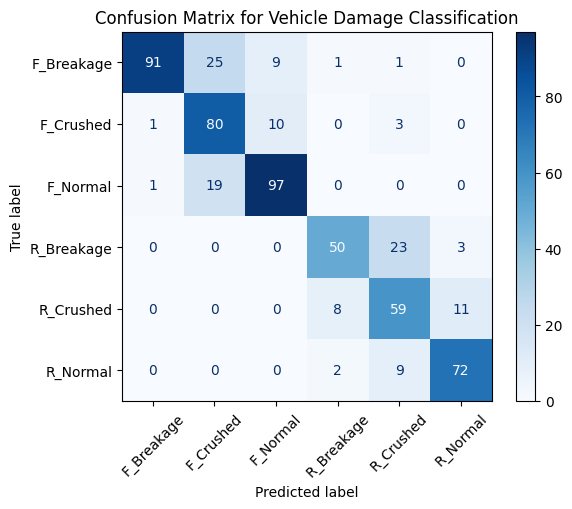

In [39]:
# Compute and plot the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [40]:
# Save the trained model
torch.save(model.state_dict(), 'saved_model.pth')